In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# try a dataset, save all spectrograms somewhere
folders = glob.glob("/home/kchow/datasets/genres/*")
filenames = []
for f in folders:
    filenames.append(glob.glob(str(f) + '/*'))
#print(filenames)
    
#filename2 = glob.glob("/home/kchow/datasets/genres/blues/*")
spectrogram_clips = []
mel_spectrogram_clips = []

restart = False

number_of_clips = 1000

spec_file = 'spec_clips_sample.npy'

mel_spec_file = 'mel_spec_clips_sample.npy'

duration = 5.0
time_steps = 216

# if numpy loaded 
if not restart and os.path.isfile(spec_file) and os.path.isfile(mel_spec_file):
    spectrogram_clips = np.load(spec_file)
    mel_spectrogram_clips = np.load(mel_spec_file)
else:
    for folder in filenames:
        for f in folder:
            print(f)
            y, sr = librosa.load(f, duration=duration)
            D = np.abs(librosa.stft(y))**2
            print(np.shape(D))
            D = D[:1024,:1939]
            S = librosa.feature.melspectrogram(S=D)
            S = S[:128,:1939]
            if np.shape(D)[0] != 1024 or np.shape(D)[1] != time_steps or np.shape(S)[0] != 128 or np.shape(S)[1] != time_steps:
                continue
            spectrogram_clips.append(D)
            mel_spectrogram_clips.append(S)
            if len(spectrogram_clips) == number_of_clips:
                break

np.save(spec_file, np.array(spectrogram_clips))
np.save(mel_spec_file, np.array(mel_spectrogram_clips))


In [3]:
# somethign wrong with snipping? Or when librosa loads need to change it. Or different dataset. 
snip_spectrogram_clips = spectrogram_clips[:]
np.shape(snip_spectrogram_clips)

(1000, 1024, 216)

In [4]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[3])

-795272.12

In [5]:
# flatten
# standardscalar and whiten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (np.shape(snip_spectrogram_clips)[0], time_steps*1024))

scaler = StandardScaler()
snip_spectrogram_clips = scaler.fit_transform(snip_spectrogram_clips)

# no whiten first
"""
pca = PCA(whiten=True)
set_trace()
snip_spectrogram_clips = pca.fit_transform(snip_spectrogram_clips)
"""
# snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (np.shape(snip_spectrogram_clips)[0], 1024, time_steps))

"""
snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), time_steps*1024))
snip_spectrogram_clips = scaler.inverse_transform(snip_spectrogram_clips)
snip_spectrogram_clips = pca.inverse_transform(snip_spectrogram_clips)
snip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), 1024, time_steps))
"""




'\nsnip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), time_steps*1024))\nsnip_spectrogram_clips = scaler.inverse_transform(snip_spectrogram_clips)\nsnip_spectrogram_clips = pca.inverse_transform(snip_spectrogram_clips)\nsnip_spectrogram_clips = np.reshape(snip_spectrogram_clips, (len(snip_spectrogram_clips), 1024, time_steps))\n'

In [6]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[3])

-951.4892

In [78]:
batch_size = 32
epochs = 100
no_cuda = False
seed = 1
beta = 1
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 20
fc_dimensions = 20
print(torch.cuda.current_device())
torch.cuda.set_device(1)
print(torch.cuda.current_device())

1
1


In [79]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [80]:

#time_steps = 200
freq_filters = 1024
channels = 10
k_size = 3
a = 122
b = 94 #1933
# with max pooling new dimensions 
c = 167
d = 32
class MusicSpecVAEConv2D(nn.Module):
    def __init__(self):
        super(MusicSpecVAEConv2D, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=k_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=k_size)
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=k_size)
        
        self.maxpool1 = nn.MaxPool2d((3, 3), return_indices=True)
        self.maxpool2 = nn.MaxPool2d((2, 2), return_indices=True)
        
        self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        # max pool
        # batch norm 
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.bn3 = nn.BatchNorm2d(channels)
        
        self.bn4 = nn.BatchNorm2d(channels)
        self.bn5 = nn.BatchNorm2d(channels)
        self.bn6 = nn.BatchNorm2d(channels)
        
        # 23 
        
        self.fc1 = nn.Linear(c*d*channels, fc_dimensions)
        self.fc3 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc4 = nn.Linear(fc_dimensions, c*d*channels)
 
        self.deconv1 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose2d(channels, channels, kernel_size=k_size)
        self.deconv3 = nn.ConvTranspose2d(channels, 1, kernel_size=k_size)
        
        self.maxunpool1 = nn.MaxUnpool2d((2, 2))
        self.maxunpool2 = nn.MaxUnpool2d((3, 3))
        
        self.indicespool1 = None
        self.indicespool2 = None
        
        #self.outputsizepool1 = torch.Tensor([1, 2])
        #self.outputsizepool2 = torch.Tensor([3, 4])
    
    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        self.outputsizepool1 = x.size()
        x, self.indicespool1 = self.maxpool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        self.outputsizepool2 = x.size()
        x, self.indicespool2 = self.maxpool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        
        return self.mu_i(x), self.var_i(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        #set_trace()
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(z.size(0), channels, c, d)
        z = F.relu(self.bn4(self.deconv1(z)))
        z = self.maxunpool1(z, self.indicespool2, output_size = self.outputsizepool2)
        z = F.relu(self.bn5(self.deconv2(z)))
        # size aint right
        z = self.maxunpool2(z, self.indicespool1, output_size = self.outputsizepool1)
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [81]:
model = MusicSpecVAEConv2D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []
beta = 0

def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + (beta*(KLD)/recon_x.size(0))

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = list(snip_spectrogram_clips[:1000])
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)

        data = torch.from_numpy(data)
        data = data.view(data.size(0), 1, freq_filters, time_steps)
        #set_trace()
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss/float(len(subset_data))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [82]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[1])

12547.216

1 0.623981237411
1 1.01745402813
1 1.35157489777
1 0.548432588577
1 0.450614690781
1 1.56524193287
1 0.968232452869
1 1.07738804817
1 0.578948259354
1 0.863558590412
1 0.527801990509
1 0.971223711967
1 0.96297955513
1 0.909295797348
1 1.02352583408
1 0.993932664394
1 0.635813117027
1 0.707752883434
1 0.700216770172
1 1.0450605154
1 0.994859397411
1 0.74529504776
1 0.941669881344
1 1.3900822401
1 0.917741119862
1 1.17764639854
1 1.07971811295
1 1.26014006138
1 0.752136647701
1 0.687016427517
1 0.312773287296
1 1.70143818855
====> Epoch: 1 Average loss: 0.0295
2 1.03779065609
2 0.651680111885
2 0.725148499012
2 0.557044684887
2 1.21658110619
2 0.662078619003
2 0.535685062408
2 0.592837274075
2 1.51096963882
2 0.6014534235
2 0.795788109303
2 0.946883320808
2 1.25542879105
2 1.24828779697
2 0.781222641468
2 1.10523056984
2 0.560281455517
2 0.65828794241
2 1.0179451704
2 0.873097538948
2 0.518991529942
2 0.396539896727
2 0.583635210991
2 0.985239505768
2 0.83165282011
2 1.02656340599
2 1.21

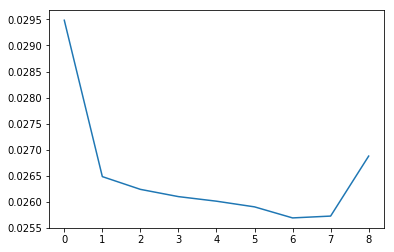

In [83]:
for epoch in range(1, 10):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()

In [71]:
np.sum(snip_spectrogram_clips[0] - snip_spectrogram_clips[1])

12547.216

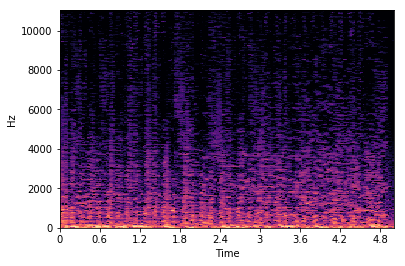

In [84]:
# AE
# reconstruct signal and see how it looks.
# out of memory gucked

# add all boys into samples
#sample = snip_spectrogram_clips[:]

with torch.no_grad():
    sample = torch.from_numpy(snip_spectrogram_clips[200:202])
    #sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(len(sample), 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    z = model.reparameterize(mu, logvar)
    #set_trace()
    # manipulation here if needed
    # why no change? Still exactly the same shit. 
    
    
    """
    z3 = torch.randn_like(z)
    
    for i in range(z.size()[0]):
        for j in range(latent_dimensions):
            z3[i][j] = 100*random.random()
    
    z2 = torch.randn_like(z)
    """
    """
    print("Before", z)
    for i in range(z.size()[0]):
        for j in range(latent_dimensions):
            z[i][j] = 100*random.random() - 50
    print("After", z)
    """
    sample = model.decode(z).cpu()
    #sample2 = model.decode(z2).cpu()
    #sample3 = model.decode(z3).cpu()

sample = np.reshape(sample.numpy(), (len(sample), freq_filters*time_steps))
shaper = np.shape(sample)
#sample = 10*np.random.rand(shaper[0], shaper[1])
#sample_2 = np.reshape(sample2.numpy(), (len(sample), freq_filters*time_steps))
#sample_3 = np.reshape(sample3.numpy(), (len(sample), freq_filters*time_steps))
#print(np.sum(sample[1] - snip_spectrogram_clips[1]), np.sum(sample_2[1] - snip_spectrogram_clips[1]), np.sum(sample_3[1] - snip_spectrogram_clips[1]))
#print(np.sum(sample[1] - sample_2[1]), np.sum(sample_2[1] - sample_3[1]), np.sum(sample_3[1] - sample[1]))
sample = scaler.inverse_transform(sample)
#sample_2 = scaler.inverse_transform(sample_2)
#sample_3 = scaler.inverse_transform(sample_3)
sample = np.reshape(sample, (len(sample), freq_filters, time_steps))
#sample_2 = np.reshape(sample_2, (len(sample), freq_filters, time_steps))
#sample_3 = np.reshape(sample_3, (len(sample), freq_filters, time_steps))

#print(np.sum(sample[1] - spectrogram_clips[1]), np.sum(sample_2[1] - spectrogram_clips[1]), np.sum(sample_3[1] - spectrogram_clips[1]))

#set_trace()
# why does it all look the same here? 
choice = 0
test_sample = sample[choice]
#test_sample_2 = sample_2[choice]
#test_sample_3 = sample_3[choice]
librosa.display.specshow(librosa.amplitude_to_db(test_sample, ref=np.max), y_axis='linear', x_axis='time')

y_out = librosa.istft(test_sample, length=110122)
IPython.display.Audio(data=y_out, rate=22050)



292090.0


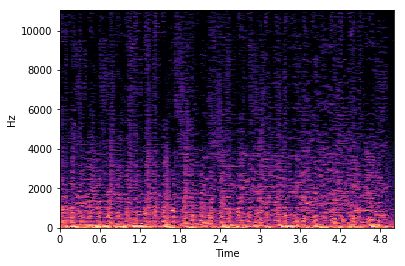

In [85]:
# AE
# reconstruct signal and see how it looks.
# out of memory gucked

# add all boys into samples
#sample = snip_spectrogram_clips[:]
with torch.no_grad():
    sample = torch.from_numpy(snip_spectrogram_clips[200:202])
    sample = sample.contiguous().view(len(sample), 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    z = model.reparameterize(mu, logvar)
    #set_trace()
    # manipulation here if needed
    # why no change? Still exactly the same shit. 
    
    #print("Before", z)
    """
    z3 = torch.randn_like(z)
    
    for i in range(z.size()[0]):
        for j in range(latent_dimensions):
            z3[i][j] = 100*random.random()
    
    z2 = torch.randn_like(z)
    """
    
    for i in range(z.size()[0]):
        for j in range(latent_dimensions):
            z[i][j] = 100*random.random() - 50
    #print("After", z)
    sample1 = model.decode(z).cpu()
    #sample2 = model.decode(z2).cpu()
    #sample3 = model.decode(z3).cpu()
sample = np.reshape(sample1.numpy(), (len(sample), freq_filters*time_steps))
#sample_2 = np.reshape(sample2.numpy(), (len(sample), freq_filters*time_steps))
#sample_3 = np.reshape(sample3.numpy(), (len(sample), freq_filters*time_steps))
#print(np.sum(sample[1] - snip_spectrogram_clips[1]), np.sum(sample_2[1] - snip_spectrogram_clips[1]), np.sum(sample_3[1] - snip_spectrogram_clips[1]))
#print(np.sum(sample[1] - sample_2[1]), np.sum(sample_2[1] - sample_3[1]), np.sum(sample_3[1] - sample[1]))
sample = scaler.inverse_transform(sample)
#sample_2 = scaler.inverse_transform(sample_2)
#sample_3 = scaler.inverse_transform(sample_3)
sample = np.reshape(sample, (len(sample), freq_filters, time_steps))
#sample_2 = np.reshape(sample_2, (len(sample), freq_filters, time_steps))
#sample_3 = np.reshape(sample_3, (len(sample), freq_filters, time_steps))

#print(np.sum(sample[1] - spectrogram_clips[1]), np.sum(sample_2[1] - spectrogram_clips[1]), np.sum(sample_3[1] - spectrogram_clips[1]))

#set_trace()
# why does it all look the same here? 
choice = 0
test_sample_rando = sample[choice]
#test_sample_2 = sample_2[choice]
#test_sample_3 = sample_3[choice]
librosa.display.specshow(librosa.amplitude_to_db(test_sample_rando, ref=np.max), y_axis='linear', x_axis='time')

y_out = librosa.istft(test_sample, length=110122)


print(np.sum(test_sample - test_sample_rando))
IPython.display.Audio(data=y_out, rate=22050)



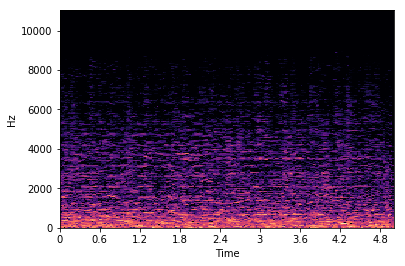

In [85]:
librosa.display.specshow(librosa.amplitude_to_db(test_sample_2, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample_2, length=110122)
IPython.display.Audio(data=y_out, rate=22050)

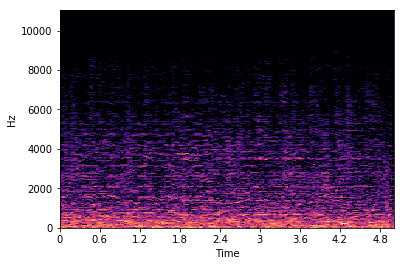

In [86]:
librosa.display.specshow(librosa.amplitude_to_db(test_sample_3, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample_3, length=110122)
IPython.display.Audio(data=y_out, rate=22050)

In [209]:
np.sum(test_sample_2 - test_sample_3)

-422091.78

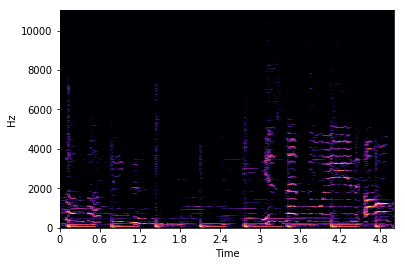

In [90]:
sample_snip = spectrogram_clips[0]
librosa.display.specshow(librosa.amplitude_to_db(sample_snip, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(sample_snip, length=110122)
IPython.display.Audio(data=y_out, rate=22050)

In [ ]:
sum(spectrogram_clips[0] - spectrogram_clips[1])

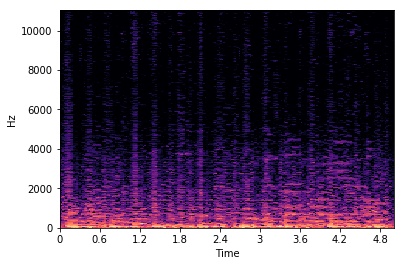

In [88]:
# random latent
n = 100
a = np.random.rand(n, 1, freq_filters, time_steps)
a = spectrogram_clips[:100]

# encoder DEFINITELY being affected! damn. So what now though? 
with torch.no_grad():
    #b = torch.Tensor(10)
    #a = torch.rand((n, 1, freq_filters, time_steps))
    #sample = b*a.expand_as(b) # multiply by 10!
    # try snip guy
    sample = torch.from_numpy(a)
    sample = sample.contiguous().view(len(sample), 1, freq_filters, time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    # encode some random thing just to get a size
    # is the encoder really affecting or something? 
    random_z = torch.randn(n, latent_dimensions).to(device)
    random_sample = model.decode(random_z).cpu()
rs = np.reshape(random_sample.numpy(), (len(random_sample), freq_filters*time_steps))
rs = scaler.inverse_transform(rs)
rs = np.reshape(rs, (len(rs), freq_filters, time_steps))
#set_trace()
# why does it all look the same here? 
test_sample = rs[0]
librosa.display.specshow(librosa.amplitude_to_db(test_sample, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample, length=110122)
IPython.display.Audio(data=y_out, rate=22050)
    

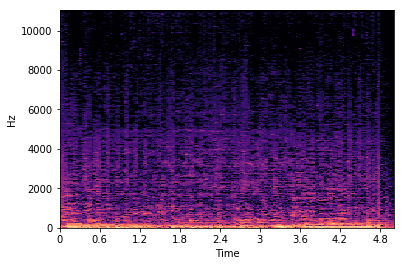

In [89]:
test_sample = rs[1]
librosa.display.specshow(librosa.amplitude_to_db(test_sample, ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(test_sample, length=110122)
IPython.display.Audio(data=y_out, rate=22050)